In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [47]:
import os
import glob
import sys
import pandas as pd
module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
from ipv_workbench.translators import panelizer
from ipv_workbench.utilities import utils
from ipv_workbench.translators import mapping_irradiance as ipv_irrad
from ipv_workbench.sample import dummies
from ipv_workbench.simulator import calculations as ipv_calc
from ipv_workbench.utilities import time_utils
import pickle
from pprint import pprint
import numpy as np
import pvlib
import matplotlib.pyplot as plt
import random
from ipv_workbench.visualize import plots as ipv_plots

# Intial Setup of object

In [3]:
PROJECT_FOLDER = "/Users/jmccarty/Desktop/bano_simulations"
BUILDING ="B1391"
pickle_in = os.path.join(PROJECT_FOLDER,"panelizer",BUILDING,"panelizer_pbano_B1391.pickle")

po = panelizer.PanelizedObject(pickle_in, PROJECT_FOLDER)
po.set_analysis_period(0,8760,1)



In [29]:
# for surface in po.get_surfaces():
#     for string in po.get_strings(surface):
#         for module in po.get_modules(surface, string):
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[0]
module = po.get_modules(surface,string)[0]


In [30]:
# build parameters for module
module_details = po.get_dict_instance([surface,string,module])['DETAILS']

parameters = utils.get_cec_data(module_details['cec_key'],file_path=po.CEC_DATA)
custom_module_data = pd.read_csv(po.MODULE_CELL_DATA,index_col='scenario').loc[module_details['module_type']].to_dict()

for k,v in custom_module_data.items():
    parameters[k] = v
    
parameters['N_subcells'] = int(max(parameters['Nsubcell_col'],parameters['Nsubcell_row']))
for k,v in parameters.items():
    if type(v) is str:
        try:
            parameters[k] = float(v)
        except ValueError:
            pass

# Sample Irradiance

In [31]:
def load_irradiance_file(bldg_radiance_dir,rad_surface_key,component):
    radiance_results_dir = os.path.join(bldg_radiance_dir, f"surface_{rad_surface_key}", "results")
    component_results_dir = os.path.join("annual_irradiance","results",f"{component}")
    sun_up_path = os.path.join(radiance_results_dir,component_results_dir,"sun-up-hours.txt")
    ill_path = glob.glob(os.path.join(radiance_results_dir,component_results_dir,"*.ill"))[0]
    return utils.build_full_ill(sun_up_path,ill_path)
   
def load_grid_file(bldg_radiance_dir,rad_surface_key):
    radiance_results_dir = os.path.join(bldg_radiance_dir, f"surface_{rad_surface_key}", "results")
    pts_path = glob.glob(os.path.join(radiance_results_dir,"annual_irradiance","model","grid","*.pts"))[0]
    return pd.read_csv(pts_path ,delimiter=" ",header=None, names=["X","Y","Z","X_v","Y_v","Z_v"])

In [32]:
surface = po.get_surfaces()[2]
string = po.get_strings(surface)[1]
module = po.get_modules(surface,string)[2]

In [33]:
rad_surface_key = po.get_dict_instance([surface])['DETAILS']['radiance_surface_label']

total_ill = load_irradiance_file(po.RADIANCE_DIR, rad_surface_key, "total")
direct_ill = load_irradiance_file(po.RADIANCE_DIR, rad_surface_key, "direct")
diffuse_ill = pd.DataFrame(np.where(total_ill < direct_ill, direct_ill*0.01, total_ill - direct_ill))
grid_pts = load_grid_file(po.RADIANCE_DIR, rad_surface_key)


In [89]:
# get hoy irrad and transofmr to effective irrad

# G_diff_hoy = ipv_irrad.collect_raw_irradiance(pv_cells_xyz_arr, sensor_pts_xyz_arr,
#                                               diffuse_ill.loc[hoy].values)
# G_dir_hoy = ipv_irrad.collect_raw_irradiance(pv_cells_xyz_arr, sensor_pts_xyz_arr, 
#                                              direct_ill.loc[hoy].values)

In [34]:

pv_cells_xyz_arr = np.array(po.get_cells_xyz(surface,string,module))
sensor_pts_xyz_arr = grid_pts[['X','Y','Z']].values

G_dir_ann = ipv_irrad.collect_raw_irradiance(pv_cells_xyz_arr,
                                 sensor_pts_xyz_arr, 
                                 direct_ill.T.values)
G_diff_ann = ipv_irrad.collect_raw_irradiance(pv_cells_xyz_arr,
                                 sensor_pts_xyz_arr, 
                                 diffuse_ill.T.values)

In [35]:
# calculate effective irradiance
sensor_vector_xyz_arr = grid_pts[['X_v', 'Y_v', 'Z_v']].values

evaluated_normal_vector = tuple(po.get_dict_instance(
    [surface, string, module])['CELLSNORMALS'][0])
front_cover = po.get_dict_instance([surface, string, module])[
    'LAYERS']['front_film']

# G_eff_hoy = ipv_irrad.calculate_effective_irradiance(G_dir_hoy,
#                                                      G_diff_hoy,
#                                                      evaluated_normal_vector,
#                                                      hoy,
#                                                      po.tmy_file,
#                                                      front_cover_color=front_cover)


In [108]:
tmy_location = utils.tmy_location(po.tmy_file)
dbt = po.tmy_dataframe['drybulb_C'].values
psl = po.tmy_dataframe['atmos_Pa'].values

# calcualte the effectivate irradiance for the year
G_eff_ann = ipv_irrad.calculate_effective_irradiance_timeseries(G_dir_ann,
                                                    G_diff_ann,
                                                    evaluated_normal_vector,
                                                    po.all_hoy,
                                                    tmy_location,
                                                    psl,
                                                    dbt,
                                                    front_cover)

In [109]:


# restrucutre the arrays following the general shape of the template (top right first)
ncols = po.get_dict_instance([surface,string,module])['DETAILS']['n_cols']
nrows = po.get_dict_instance([surface,string,module])['DETAILS']['n_rows']
hoy_arrs = []
for hoy in np.arange(0,8760):
    G_eff_hoy_arr = np.round(np.fliplr(G_eff_ann[:,hoy].reshape(-1,nrows)).T,2)
    hoy_arrs.append(G_eff_hoy_arr)

G_eff_ann = np.array(hoy_arrs)

# calculate cell temperature
C_temp_ann_arr = ipv_calc.calculate_cell_temperature(G_eff_ann,
                                                     po.tmy_dataframe['drybulb_C'].values,
                                                     ).reshape((nrows, ncols,  len(po.all_hoy)))
po.get_dict_instance([surface,string,module])['CELLSTEMP'] = C_temp_ann_arr.copy()

# rebuild array
po.get_dict_instance([surface,string,module])['CELLSIRRADEFF'] = G_eff_ann.reshape((nrows, ncols,  len(po.all_hoy))).copy()


In [229]:
# generate module masks

# 
module_template = po.get_dict_instance([surface,string,module])['DETAILS']['module_type']

def get_orientation(module_template_orientation):
    if module_template_orientation=="P":
        return "portrait"
    elif module_template_orientation=="L":
        return "landscape"
    else:
        print("Not a correct code. Need either P (portrait) or L (landscape)")
        
def get_cell_type(module_template_cell):
    if module_template_cell=="A":
        return "monocrystalline"
    elif module_template_cell=="B":
        return "polycrystalline"
    elif module_template_cell=="C":
        return "cdte"
    elif module_template_cell=="D":
        return "cigs"
    elif module_template_cell=="E":
        return "asi"
    
cell_type = get_cell_type(module_template[0])
orientation = get_orientation(module_template[1])

map_file = [fp for fp in po.map_files if f"{cell_type}_{orientation}" in fp][0]
submodule_map, diode_map, subcell_map = utils.read_map_excel(map_file)

po.get_dict_instance([surface,string,module])['MAPS']['SUBMODULES'] = submodule_map
po.get_dict_instance([surface,string,module])['MAPS']['DIODES'] = diode_map
po.get_dict_instance([surface,string,module])['MAPS']['SUBCELLS'] = subcell_map

In [204]:
submodule_map, diode_map, subcell_map = utils.read_map_excel("/Users/jmccarty/Nextcloud/Teaching/22_HS/polikseni_bano/polikseni_share/PV datasheets/final_selection/maps/monocrystalline_landscape_maps.xlsx")

In [253]:
# build new maps
hoy = 0

# irrad_hoy = po.get_dict_instance([surface,string,module])['CELLSIRRADEFF'][:,:,hoy]
# temp_hoy = po.get_dict_instance([surface,string,module])['CELLSTEMP'][:,:,hoy]



def remap_monocrystalline(parameters, diode_map):
    actual_cols = parameters['n_cols']
    actual_rows = parameters['n_rows']
    
    if parameters['orientation']=='portrait':
        if (actual_cols > 3) & (actual_rows > 5):
            # build new submodule_map
            if actual_rows % 2:
                # temp_submodule = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_submodule[int(len(temp_submodule)/2):] = 1
                # new_submodule_map = temp_submodule.reshape((actual_rows,actual_cols))
                new_submodule_map = np.zeros((actual_rows,actual_cols))
            else:
                new_submodule_map = np.zeros((actual_rows,actual_cols))
                new_submodule_map[int(actual_rows/2):,] = 1
            
            if actual_cols % 2:
                # temp_diode = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_diode[int(len(temp_diode)/2):] = 1 
                # new_diode_map = temp_diode.reshape((actual_cols,actual_rows)).T
                new_diode_map = np.zeros((actual_rows,actual_cols))
            else:
                new_diode_map = diode_map[0:actual_rows,0:actual_cols] 
        else:
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            new_diode_map = np.zeros((actual_rows,actual_cols))
            
      
    elif parameters['orientation']=='landscape':
        if (actual_rows > 3) & (actual_cols > 5):
            # build new submodule_map
            if actual_cols % 2:
                # temp_submodule = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_submodule[int(len(temp_submodule)/2):] = 1
                # new_submodule_map = temp_submodule.reshape((actual_rows,actual_cols))
                new_submodule_map = np.zeros((actual_rows,actual_cols))
            else:
                new_submodule_map = np.zeros((actual_rows,actual_cols))
                new_submodule_map[:,int(actual_cols/2):] = 1
            
            if actual_rows % 2:
                # temp_diode = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_diode[int(len(temp_diode)/2):] = 1 
                # new_diode_map = temp_diode.reshape((actual_cols,actual_rows)).T
                new_diode_map = np.zeros((actual_rows,actual_cols))
            else:
                new_diode_map = diode_map[0:actual_rows,0:actual_cols]     
        else:
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            new_diode_map = np.zeros((actual_rows,actual_cols))
        
    new_subcell_map = np.zeros((actual_rows,actual_cols))
    N_p = int(len(np.unique(submodule_map)))
    N_s = int((actual_cols * actual_rows) / N_p)
    N_subcells = 1
    return new_submodule_map, new_diode_map, new_subcell_map, N_s, N_p, N_subcells




0.4605832719391758 10.247690789010258 4.719914953423299


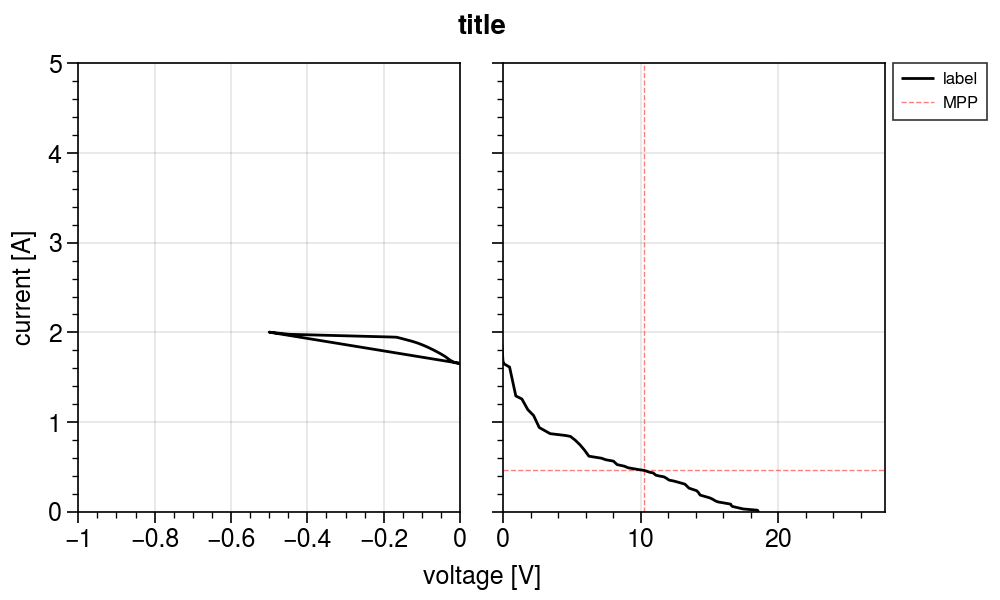

In [256]:

Imod, Vmod = ipv_calc.calculate_module_curve_multiple_column(irrad_hoy,
                                                             temp_hoy,
                                                             parameters,
                                                             po.get_dict_instance([surface,string,module])['MAPS']['SUBMODULES'],
                                                             po.get_dict_instance([surface,string,module])['MAPS']['DIODES'])
Pmod = Imod*Vmod
print(Imod[np.argmax(Pmod)],Vmod[np.argmax(Pmod)],np.max(Pmod))
ipv_plots.plot_curves(Imod,
                      Vmod,
                      parameters,
                      y_max=5,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      )

In [97]:
po.get_dict_instance([surface,string,module])['CELLSIRRADEFF'][:,:,0].shape

(6, 20)

# Archive

In [30]:

cells = po.get_dict_instance([surface, string, module])['CELLSXYZ']
module_details = po.get_dict_instance([surface, string, module])['DETAILS']
# cells = utils.flatten_list(cells)


# x = []
# y = []
# z = []
# label = []
# for n, cell in enumerate(cells):
#     x.append(cell[0])
#     y.append(cell[1])
#     z.append(cell[2])
#     label.append(n)


# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')


# ax.scatter(x, y, z)

# for x, y, z, label in zip(x, y, z, label):
#     ax.text(x, y, z, label)

# plt.show()


ValueError: cannot reshape array of size 240 into shape (20,4)